In [77]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

Reading and observing the dataset at hand

In [2]:
ls

NNDL_HW2.pdf          house prices.csv
data_description.txt  regression.ipynb


In [63]:
df = pd.read_csv('house prices.csv')
df.drop('Id', inplace=True, axis=1)

In [64]:
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [66]:
def show_nans():
    nan_df = pd.DataFrame(df.isna().sum(axis=0), columns=['nan-count'])
    nan_df = nan_df.sort_values('nan-count', ascending=False)
    return nan_df

Removing Nan values if possible and replacing them with the Nan values defined specifically for each

In [67]:
df['PoolQC'].fillna('NA', inplace=True)
df['MiscFeature'].fillna('NA', inplace=True)
df['Alley'].fillna('NA', inplace=True)
df['Fence'].fillna('NA', inplace=True)
df['FireplaceQu'].fillna('NA', inplace=True)
df['GarageCond'].fillna('NA', inplace=True)
df['GarageFinish'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)
df['GarageType'].fillna('NA', inplace=True)
df['BsmtFinType2'].fillna('NA', inplace=True)
df['BsmtFinType1'].fillna('NA', inplace=True)
df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True) # should be experimented
show_nans()

,nan-count
GarageYrBlt,81
MasVnrType,8
MasVnrArea,8
Electrical,1
KitchenQual,0
...,...
ExterCond,0
ExterQual,0
Exterior2nd,0
Exterior1st,0


In [68]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [69]:
df.shape

(1370, 80)

In [70]:
number_df = df.select_dtypes('number')
object_df = df.select_dtypes('object')

In [71]:
number_df.shape, object_df.shape

((1370, 37), (1370, 43))

In [74]:
object_df.head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [75]:
number_df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

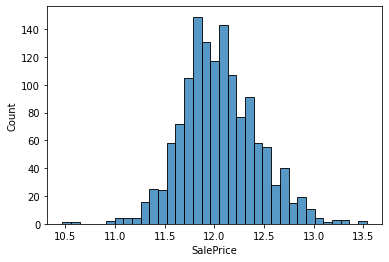

In [80]:
sns.histplot(np.log(number_df['SalePrice']))

Making the data loader considering the batch sizes for train and test

In [97]:
def to_dataloader(df, target_col):
    target = torch.tensor(df[target_col].values.astype(np.float32))
    data = torch.tensor(df.drop(target_col, axis=1).values.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=32)
    return data_loader

In [99]:
for data, target in data_loader:
    print(data.shape, target.shape)
    break

torch.Size([32, 36]) torch.Size([32])


In [100]:
train_df = number_df.sample(frac=.8, random_state=707)
test_df = number_df.drop(train_df.index)

train_loader = to_dataloader(
    df=train_df, 
    target_col='SalePrice'
)
test_loader = to_dataloader(
    df=test_df, 
    target_col='SalePrice'
)